# Brachistocrone indirect Multiple Shooting

In [1]:
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')


def multiple_shooting(initial_states, final_states, guesses, K, is_print=False):

    def objective(obj0):
        if is_print:
            print("\nDecision vector: ", obj0)
        global theta_array
        tf = obj0[3]
        ptot0 = np.reshape(obj0[4:], [2*nx, K-1])
        points = 1000
        E_array = np.empty([K-1, nx*2])

        for k in range(K):
            if k == 0:
                p0 = [x0, y0, v0, obj0[0], obj0[1], obj0[2]]
            else:
                p0 = ptot0[:, k-1]

            tau_eval = np.linspace(tau[k], tau[k+1], points)

            sol = solve_ivp(dynamics, [tau[k], tau[k+1]],
                            p0, t_eval=tau_eval, args=(t0, tf), dense_output=False, method='RK45')
            # print(sol.message)

            x = sol.y[0]
            y = sol.y[1]
            v = sol.y[2]
            lambx = sol.y[3]
            lamby = sol.y[4]
            lambv = sol.y[5]

            if k < K-1:
                ptots_end = ptot0[:, k]
                eq1 = x[-1] - ptots_end[0]
                eq2 = y[-1] - ptots_end[1]
                eq3 = v[-1] - ptots_end[2]
                eq4 = lambx[-1]-1 - ptots_end[3]
                eq5 = lamby[-1]-1 - ptots_end[4]
                #print(sol.y[3], ptots_end[3])
                eq6 = lambv[-1] - ptots_end[5]
                E_array[k, :] = [eq1, eq2, eq3, eq4, eq5, eq6]
                #print([eq1, eq2, eq3, eq4])

        H = lambx[-1]*v[-1]*np.sin(theta_array[-1]) + lamby[-1] * \
            v[-1]*np.cos(theta_array[-1]) + lambv[-1] * \
            g*np.cos(theta_array[-1])

        theta_array = []  # restart vector

        eq1f = x[-1] - xf
        eq2f = y[-1] - yf
        eq3f = lambv[-1]
        eq4f = H + 1

        E_array = np.reshape(E_array, 2*nx*(K-1))
        E_array = np.concatenate(
            (E_array, [eq1f, eq2f, eq3f, eq4f]), axis=None)

        return E_array

    def dynamics(t, s, tinitial, tfinal):
        global theta_array

        v_t = s[2]
        lambx_t = s[3]
        lamby_t = s[4]
        lambv_t = s[5]

        def solve_control(th):
            ht = lambx_t*v_t*np.cos(th) - (lamby_t*v_t + lambv_t*g)*np.sin(th)
            # print(ht)
            return ht

        full_output = False

        theta = fsolve(
            solve_control, theta_guess, full_output=full_output)
        if full_output:
            print("Theta solution found? ",
                  "yes!" if theta[2] == 1 else "No :(")
            print("msg: ", theta[3])
            print("n func calls: ", theta[1]["nfev"])
        theta = theta[0]

        theta_array.append(theta)

        x_dot = v_t*np.sin(theta)
        y_dot = v_t*np.cos(theta)
        v_dot = g*np.cos(theta)
        lambx_dot = 0
        lamby_dot = 0
        lambv_dot = -s[3]*np.cos(theta) - s[4]*np.cos(theta)
        return (tfinal-tinitial)*np.array([x_dot, y_dot, v_dot, lambx_dot, lamby_dot, lambv_dot])/2

    global x0, y0, v0, xf, yf, theta_guess, theta_array

    theta_guess = guesses[4]
    theta_array = []

    xf = final_states[0]
    yf = final_states[1]
    x0 = initial_states[0]
    y0 = initial_states[1]
    v0 = initial_states[2]

    t0 = 0

    nx = len(initial_states)

    tau = np.linspace(-1, +1, K+1)

    ptot0guess = np.zeros([2*nx, K-1])
    reshaped = np.reshape(ptot0guess, 2*nx*(K-1))
    changing = np.concatenate([guesses[0:4], reshaped])

    obj_sol, obj_dict, ier, mesg = fsolve(objective, changing, xtol=10e-8,
                                          full_output=True)
    print("Solution found? ", "yes!" if ier == 1 else "No :(")
    print("msg: ", mesg)
    print("n func calls: ", obj_dict["nfev"])

    tf = obj_sol[3]
    ptot0 = np.reshape(obj_sol[4:], [2*nx, K-1])
    points = 100
    tau_array = np.empty([K, points])
    y_array = np.empty([K, points])
    x_array = np.empty([K, points])
    v_array = np.empty([K, points])
    for k in range(K):
        if k == 0:
            p0 = [x0, y0, v0, obj_sol[0], obj_sol[1], obj_sol[2]]
        else:
            p0 = ptot0[:, k-1]
        tau_eval = np.linspace(tau[k], tau[k+1], points)
        sol = solve_ivp(dynamics, [tau_eval[0], tau_eval[-1]],
                        p0, t_eval=tau_eval, args=(t0, tf), dense_output=True)
        tau_array[k] = sol.t
        x_array[k] = sol.y[0]
        y_array[k] = sol.y[1]
        v_array[k] = sol.y[2]

    plt.figure(figsize=(10, 8))
    plt.plot(np.reshape(x_array, K*points), -1*np.reshape(y_array, K*points))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Brachistocrone Curve')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.plot(np.reshape(tau_array, K*points),
             np.reshape(x_array, K*points), label='x')
    plt.plot(np.reshape(tau_array, K*points),
             np.reshape(y_array, K*points), label='y')
    # plt.plot(np.reshape(tau_array, K*points),
    #         np.reshape(v_array, K*points), label='v')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.title(f'States')
    plt.legend()
    plt.show()

## $K = 3$

Solution found?  yes!
msg:  The solution converged.
n func calls:  381
Solution found?  yes!
msg:  The solution converged.
n func calls:  30


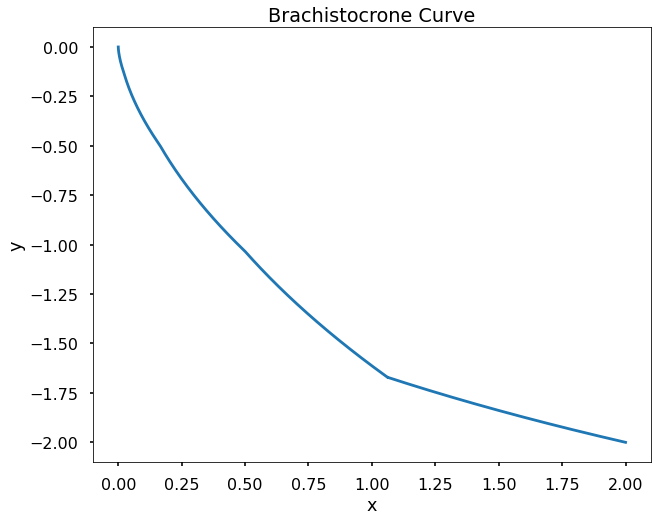

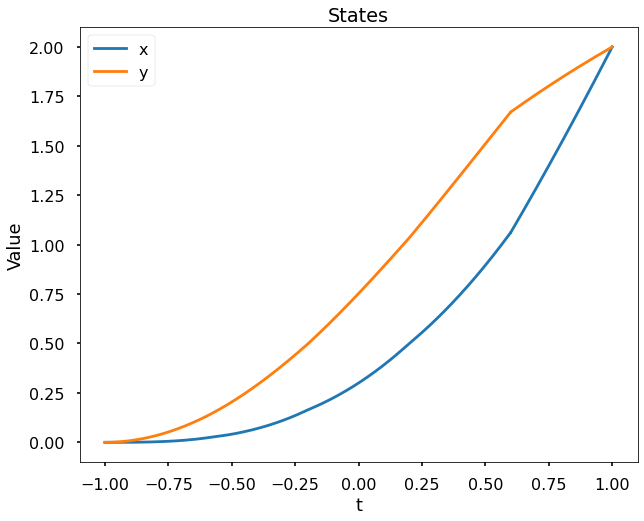

In [5]:
global g
g = 10
x0 = 0
xf = 2
y0 = 0
yf = 2
v0 = 0
#vf = free

K = 5

initial_states = [x0, y0, v0]
final_states = [xf, yf]

lamb0_guess = [1, 1, 1]
tf_guess = [10]
theta_guess = [0.5]

guesses = lamb0_guess + tf_guess + theta_guess  # list of element guesses

multiple_shooting(initial_states, final_states, guesses, K)

# K = 5

Solution found?  yes!
msg:  The solution converged.
n func calls:  381
Solution found?  yes!
msg:  The solution converged.
n func calls:  30


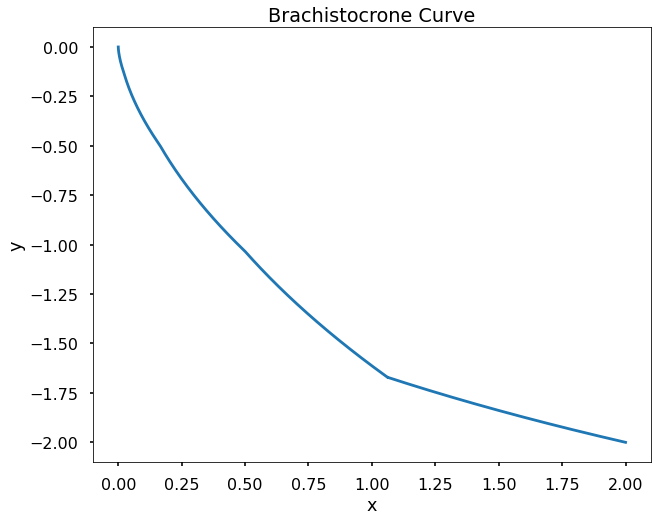

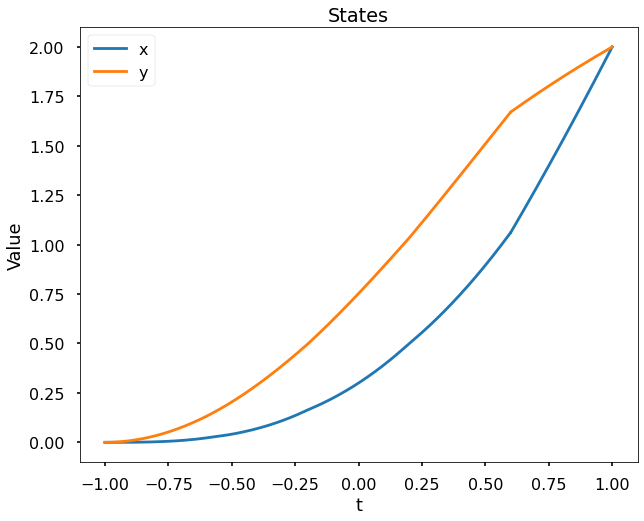

In [8]:
multiple_shooting(initial_states, final_states, guesses, 5)

### Evolution of guessses 


Decision vector:  [ 1.  1.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Decision vector:  [ 1.  1.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Decision vector:  [ 1.  1.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Decision vector:  [ 1.00000001  1.          1.         10.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]

Decision vector:  [ 1.          1.00000001  1.         10.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.   


Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00]

Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00]

Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000


Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.49011612e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

Decision vector:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+01
 0.00000000e+00 0.00000000


Decision vector:  [ 1.22256023e+00  9.25029243e-01  1.85642469e+00  7.68167968e+00
 -5.46303433e+00 -2.22736564e+00 -7.30488918e+00 -7.46340640e-01
  7.91732175e+00  8.25190928e+00  2.66726850e+00 -2.28511659e+00
  3.94455586e+00 -2.55183537e+00 -4.07287640e+00 -5.48800984e+00
  2.88942893e-09 -1.03971076e-10 -3.09737040e-09 -6.81517278e-09
 -1.70585714e-09 -4.69758383e-09 -7.69098466e-09 -9.72112964e-09
 -1.63397079e-08 -5.23916466e-08 -4.24567149e-08 -2.89248286e-08]

Decision vector:  [ 1.48799366e+00  8.53325591e-01  2.12963031e+00  4.85687527e+00
 -4.77774006e+00 -8.38361969e+00 -1.20731309e+01 -5.36365703e+00
  8.49220357e+00  1.33817361e+01  8.09498624e+00  2.98169906e+00
  4.46089646e+00 -3.72571212e+00 -4.94125050e+00 -5.23226769e+00
  3.81800547e-09 -3.92163972e-10 -9.98816155e-09 -1.76904937e-08
 -6.23031366e-09 -6.27416902e-09 -1.70581624e-08 -1.57208764e-08
 -5.67483451e-08 -9.66669118e-08 -8.71005727e-08 -5.40178835e-08]

Decision vector:  [ 1.57020915e+00  9.35018046e-0


Decision vector:  [ 1.57063564e+00  9.35441810e-01  1.53008799e+00  3.24889709e+00
 -3.53527197e+00 -1.44947109e+01 -1.83349114e+01 -1.16804553e+01
  5.87525851e+00  1.35908102e+01  9.25915877e+00  5.05788974e+00
  8.87209261e-01 -7.14494753e+00 -8.87203127e+00 -8.57387833e+00
  8.90388694e-09 -3.32827063e-09 -2.43616552e-08 -4.12133023e-08
 -4.98357523e-09 -1.23451944e-08 -3.63732036e-08 -4.06520011e-08
 -7.79233487e-08 -1.29980485e-07 -1.20233427e-07 -7.73502854e-08]

Decision vector:  [ 1.57063564e+00  9.35441810e-01  1.53008799e+00  3.24889709e+00
 -3.53527197e+00 -1.44947109e+01 -1.83349114e+01 -1.16804553e+01
  5.87525851e+00  1.35908102e+01  9.25915877e+00  5.05788974e+00
  8.87209261e-01 -7.14494753e+00 -8.87203140e+00 -8.57387820e+00
  8.90388694e-09 -3.32827063e-09 -2.43616552e-08 -4.12133023e-08
 -4.98357523e-09 -1.23451944e-08 -3.63732036e-08 -4.06520011e-08
 -7.79233487e-08 -1.29980485e-07 -1.20233427e-07 -7.73502854e-08]

Decision vector:  [ 1.57063564e+00  9.35441810e-0


Decision vector:  [ 1.53177551e+00  1.31017138e+00  8.15403278e-01  4.70712601e-02
 -2.60294733e+00 -4.45113267e+00 -4.88681115e+00 -1.83675674e+00
  2.58876318e+00  3.92710182e+00  1.06903842e+00 -2.53506412e+00
 -3.23805539e+00 -8.86710889e+00 -1.38974172e+01 -1.68990107e+01
  4.93578945e-08  1.99364200e-08 -2.13858624e-08 -6.12627308e-08
 -3.58565635e-08 -2.46576371e-08 -6.88240082e-08 -1.06587122e-07
 -2.46486196e-08 -8.90086256e-08 -9.36463580e-08 -4.55219273e-08]

Decision vector:  [ 1.53177551e+00  1.31017138e+00  8.15403278e-01  4.70712601e-02
 -2.60294733e+00 -4.45113267e+00 -4.88681115e+00 -1.83675674e+00
  2.58876314e+00  3.92710188e+00  1.06903842e+00 -2.53506412e+00
 -3.23805539e+00 -8.86710889e+00 -1.38974172e+01 -1.68990107e+01
  4.93578945e-08  1.99364200e-08 -2.13858624e-08 -6.12627308e-08
 -3.58565635e-08 -2.46576371e-08 -6.88240082e-08 -1.06587122e-07
 -2.46486196e-08 -8.90086256e-08 -9.36463580e-08 -4.55219273e-08]

Decision vector:  [ 1.53177551e+00  1.31017138e+0


Decision vector:  [ 1.52279268e+00  1.06710443e+00  7.55512815e-01 -9.40266056e-01
 -2.12062661e+00 -2.86308141e+00 -3.65040181e+00 -3.88712420e-01
  6.58523238e-01  7.40114804e-01  2.04655905e+00  6.28195879e-01
 -4.13560492e+00 -8.85903905e+00 -1.37887554e+01 -1.63746339e+01
  7.44727313e-08  9.76353008e-09 -6.37653296e-08 -1.48386761e-07
  1.89584541e-07  9.12159449e-08  2.98367867e-08 -3.47582856e-08
 -5.19587175e-09 -7.88407398e-08 -9.19083078e-08 -4.59857373e-08]

Decision vector:  [ 1.52279405e+00  1.06712359e+00  9.09698917e-01 -7.50493575e-01
 -2.14555515e+00 -2.65286274e+00 -2.45314310e+00  1.23591803e+00
  8.54515956e-01  7.20080661e-01  1.34442354e+00 -1.11342589e-01
 -3.73694576e+00 -7.67042752e+00 -1.17155738e+01 -1.42996669e+01
  1.84822975e-07  1.17214082e-07  4.41462517e-08 -2.35167949e-08
  3.46299321e-08 -1.04598569e-08 -8.60228304e-08 -1.60132727e-07
 -1.58956833e-08 -8.55633606e-08 -8.82297968e-08 -4.12137626e-08]

Decision vector:  [ 1.51951524e+00  1.04414108e+0


Decision vector:  [ 1.49212232e+00  1.01407920e+00  8.27078017e-01 -1.30850540e+00
 -7.61731801e-01 -6.44848396e-01  8.17675971e-01  3.75098862e+00
 -4.15797623e-01 -5.52517700e-01  1.21475527e-01 -1.27646898e-01
 -4.29963511e+00 -7.99616180e+00 -1.10474945e+01 -1.24518212e+01
  1.07412463e-06  7.50943611e-07  4.22292262e-07  9.50775704e-08
  7.65193788e-07  4.64170982e-07  1.33609421e-07 -1.97672421e-07
 -6.71359853e-07 -3.95651430e-07 -1.94619903e-07 -5.11143423e-08]

Decision vector:  [ 1.49212232e+00  1.01407920e+00  8.27078017e-01 -1.30850540e+00
 -7.61731801e-01 -6.44848396e-01  8.17675971e-01  3.75098862e+00
 -4.15797623e-01 -5.52517700e-01  1.21475527e-01 -1.27646898e-01
 -4.29963511e+00 -7.99616180e+00 -1.10474945e+01 -1.24518212e+01
  1.07412463e-06  7.50943611e-07  4.22292262e-07  9.50775704e-08
  7.65193777e-07  4.64170989e-07  1.33609421e-07 -1.97672421e-07
 -6.71359853e-07 -3.95651430e-07 -1.94619903e-07 -5.11143423e-08]

Decision vector:  [ 1.49212232e+00  1.01407920e+0


Decision vector:  [ 1.46273771e+00  6.69987338e-01  8.54754254e-01 -1.03623389e+00
 -4.35647394e-01 -3.11518001e-01  4.69401220e-01  1.82838058e+00
 -7.18915423e-01 -9.97262242e-01 -3.26102406e-01  3.72832925e-01
 -3.56957734e+00 -6.93737890e+00 -9.77815458e+00 -1.19384488e+01
  3.04334006e-06  2.02193254e-06  9.92617806e-07 -3.44371659e-08
  2.87887976e-06  1.87910701e-06  8.48111915e-07 -1.83202864e-07
 -2.06877420e-06 -1.04533714e-06 -3.88393302e-07 -2.83309264e-08]

Decision vector:  [ 1.46273771e+00  6.69987338e-01  8.54754254e-01 -1.03623389e+00
 -4.35647401e-01 -3.11517996e-01  4.69401220e-01  1.82838058e+00
 -7.18915423e-01 -9.97262242e-01 -3.26102406e-01  3.72832925e-01
 -3.56957734e+00 -6.93737890e+00 -9.77815458e+00 -1.19384488e+01
  3.04334006e-06  2.02193254e-06  9.92617806e-07 -3.44371659e-08
  2.87887976e-06  1.87910701e-06  8.48111915e-07 -1.83202864e-07
 -2.06877420e-06 -1.04533714e-06 -3.88393302e-07 -2.83309264e-08]

Decision vector:  [ 1.46273771e+00  6.69987338e-0


Decision vector:  [ 1.46273771e+00  6.69987338e-01  8.54754254e-01 -1.03623389e+00
 -4.35647401e-01 -3.11518001e-01  4.69401220e-01  1.82838058e+00
 -7.18915423e-01 -9.97262242e-01 -3.26102406e-01  3.72832925e-01
 -3.56957734e+00 -6.93737890e+00 -9.77815458e+00 -1.19384488e+01
  3.04334006e-06  2.02193254e-06  9.92617806e-07 -3.44371659e-08
  2.87887976e-06  1.87910701e-06  8.48111915e-07 -1.83202861e-07
 -2.06877420e-06 -1.04533714e-06 -3.88393302e-07 -2.83309264e-08]

Decision vector:  [ 1.46273771e+00  6.69987338e-01  8.54754254e-01 -1.03623389e+00
 -4.35647401e-01 -3.11518001e-01  4.69401220e-01  1.82838058e+00
 -7.18915423e-01 -9.97262242e-01 -3.26102406e-01  3.72832925e-01
 -3.56957734e+00 -6.93737890e+00 -9.77815458e+00 -1.19384488e+01
  3.04334006e-06  2.02193254e-06  9.92617806e-07 -3.44371659e-08
  2.87887976e-06  1.87910701e-06  8.48111915e-07 -1.83202864e-07
 -2.06877416e-06 -1.04533714e-06 -3.88393302e-07 -2.83309264e-08]

Decision vector:  [ 1.46273771e+00  6.69987338e-0


Decision vector:  [ 1.40700163e+00  7.51557678e-01  7.66836730e-01 -9.95380399e-01
 -3.01529639e-01 -2.38109612e-01  2.22454118e-01  1.11482640e+00
 -5.88761230e-01 -7.55981985e-01 -1.52312628e-01  5.51901241e-01
 -3.14638824e+00 -6.16801365e+00 -8.77222518e+00 -1.08069755e+01
  1.36346189e-04  9.13805229e-05  4.64056907e-05  1.43000951e-06
  1.37841478e-04  9.28961165e-05  4.79209328e-05  2.94400050e-06
 -9.79146363e-05 -4.69734828e-05 -1.58104102e-05 -8.92803433e-07]

Decision vector:  [ 1.40700163e+00  7.51557678e-01  7.66836730e-01 -9.95380399e-01
 -3.01529644e-01 -2.38109608e-01  2.22454118e-01  1.11482640e+00
 -5.88761230e-01 -7.55981985e-01 -1.52312628e-01  5.51901241e-01
 -3.14638824e+00 -6.16801365e+00 -8.77222518e+00 -1.08069755e+01
  1.36346189e-04  9.13805229e-05  4.64056907e-05  1.43000951e-06
  1.37841478e-04  9.28961165e-05  4.79209328e-05  2.94400050e-06
 -9.79146363e-05 -4.69734828e-05 -1.58104102e-05 -8.92803433e-07]

Decision vector:  [ 1.40700163e+00  7.51557678e-0


Decision vector:  [ 1.40700163e+00  7.51557678e-01  7.66836730e-01 -9.95380399e-01
 -3.01529644e-01 -2.38109612e-01  2.22454118e-01  1.11482640e+00
 -5.88761230e-01 -7.55981985e-01 -1.52312628e-01  5.51901241e-01
 -3.14638824e+00 -6.16801365e+00 -8.77222518e+00 -1.08069755e+01
  1.36346189e-04  9.13805229e-05  4.64056907e-05  1.43000951e-06
  1.37841478e-04  9.28961165e-05  4.79209328e-05  2.94400050e-06
 -9.79146348e-05 -4.69734828e-05 -1.58104102e-05 -8.92803433e-07]

Decision vector:  [ 1.40700163e+00  7.51557678e-01  7.66836730e-01 -9.95380399e-01
 -3.01529644e-01 -2.38109612e-01  2.22454118e-01  1.11482640e+00
 -5.88761230e-01 -7.55981985e-01 -1.52312628e-01  5.51901241e-01
 -3.14638824e+00 -6.16801365e+00 -8.77222518e+00 -1.08069755e+01
  1.36346189e-04  9.13805229e-05  4.64056907e-05  1.43000951e-06
  1.37841478e-04  9.28961165e-05  4.79209328e-05  2.94400050e-06
 -9.79146363e-05 -4.69734821e-05 -1.58104102e-05 -8.92803433e-07]

Decision vector:  [ 1.40700163e+00  7.51557678e-0


Decision vector:  [ 1.36522769e+00  7.89901217e-01  6.62067188e-01 -1.00140943e+00
 -2.43539160e-01 -1.24129325e-01  4.68846269e-01  1.39736690e+00
 -4.78079856e-01 -5.79463480e-01 -7.24800854e-02  5.48894963e-01
 -2.86087137e+00 -5.53673139e+00 -7.86109124e+00 -9.73353346e+00
  8.66895122e-03  5.81400274e-03  2.95904462e-03  1.04087070e-04
  8.78426927e-03  5.92934250e-03  3.07438621e-03  2.19426230e-04
 -6.17940383e-03 -2.96699985e-03 -9.98722546e-04 -5.97281796e-05]

Decision vector:  [ 1.36522769e+00  7.89901217e-01  6.62067188e-01 -1.00140943e+00
 -2.43539160e-01 -1.24129325e-01  4.68846269e-01  1.39736687e+00
 -4.78079849e-01 -5.79463480e-01 -7.24800854e-02  5.48894963e-01
 -2.86087137e+00 -5.53673139e+00 -7.86109124e+00 -9.73353346e+00
  8.66895122e-03  5.81400274e-03  2.95904462e-03  1.04087070e-04
  8.78426927e-03  5.92934250e-03  3.07438621e-03  2.19426230e-04
 -6.17940383e-03 -2.96699985e-03 -9.98722546e-04 -5.97281796e-05]

Decision vector:  [ 1.36522769e+00  7.89901217e-0


Decision vector:  [ 1.36522769e+00  7.89901217e-01  6.62067188e-01 -1.00140943e+00
 -2.43539160e-01 -1.24129325e-01  4.68846269e-01  1.39736687e+00
 -4.78079856e-01 -5.79463480e-01 -7.24800854e-02  5.48894963e-01
 -2.86087137e+00 -5.53673139e+00 -7.86109124e+00 -9.73353346e+00
  8.66895122e-03  5.81400274e-03  2.95904462e-03  1.04087070e-04
  8.78426927e-03  5.92934250e-03  3.07438621e-03  2.19426230e-04
 -6.17940383e-03 -2.96699985e-03 -9.98722531e-04 -5.97281796e-05]

Decision vector:  [ 1.36522769e+00  7.89901217e-01  6.62067188e-01 -1.00140943e+00
 -2.43539160e-01 -1.24129325e-01  4.68846269e-01  1.39736687e+00
 -4.78079856e-01 -5.79463480e-01 -7.24800854e-02  5.48894963e-01
 -2.86087137e+00 -5.53673139e+00 -7.86109124e+00 -9.73353346e+00
  8.66895122e-03  5.81400274e-03  2.95904462e-03  1.04087070e-04
  8.78426927e-03  5.92934250e-03  3.07438621e-03  2.19426230e-04
 -6.17940383e-03 -2.96699985e-03 -9.98722546e-04 -5.97281787e-05]

Decision vector:  [ 1.36013583e+00  7.94910782e-0


Decision vector:  [ 1.81240727e+00  1.40066886e+00 -1.31733761e-01 -9.72471982e-01
 -2.06307076e-01 -2.77440821e-02  5.15845616e-01  1.36027146e+00
 -3.31849326e-01 -3.27250080e-01  1.46791766e-01  7.46342651e-01
 -2.26254925e+00 -4.55916882e+00 -6.57351510e+00 -8.28076379e+00
  5.55177483e-01  3.72596454e-01  1.90015417e-01  7.43438364e-03
  5.63388060e-01  3.80807046e-01  1.98226011e-01  1.56449699e-02
 -3.87608785e-01 -1.86677244e-01 -6.31072514e-02 -4.12752476e-03]

Decision vector:  [ 1.81240727e+00  1.40066886e+00 -1.31733761e-01 -9.72471982e-01
 -2.06307076e-01 -2.77440821e-02  5.15845608e-01  1.36027148e+00
 -3.31849326e-01 -3.27250080e-01  1.46791766e-01  7.46342651e-01
 -2.26254925e+00 -4.55916882e+00 -6.57351510e+00 -8.28076379e+00
  5.55177483e-01  3.72596454e-01  1.90015417e-01  7.43438364e-03
  5.63388060e-01  3.80807046e-01  1.98226011e-01  1.56449699e-02
 -3.87608785e-01 -1.86677244e-01 -6.31072514e-02 -4.12752476e-03]

Decision vector:  [ 1.81240727e+00  1.40066886e+0


Decision vector:  [ 2.77202130e+00  2.63371500e+00 -1.57316323e+00 -9.00372308e-01
 -9.83942277e-02 -5.62844134e-03  3.57650007e-01  1.04638479e+00
 -8.76570831e-02  5.64709067e-02  5.79253191e-01  1.15551978e+00
 -1.52518957e+00 -3.52596428e+00 -5.29372951e+00 -6.79993963e+00
  1.64376062e+00  1.10872084e+00  5.73681059e-01  3.86412795e-02
  1.65185691e+00  1.11681714e+00  5.81777361e-01  4.67375768e-02
 -1.05256644e+00 -5.08112627e-01 -1.72579862e-01 -1.24933574e-02]

Decision vector:  [ 2.77202126e+00  2.63371504e+00 -1.57316323e+00 -9.00372308e-01
 -9.83942277e-02 -5.62844134e-03  3.57650007e-01  1.04638479e+00
 -8.76570831e-02  5.64709067e-02  5.79253191e-01  1.15551978e+00
 -1.52518957e+00 -3.52596428e+00 -5.29372951e+00 -6.79993963e+00
  1.64376062e+00  1.10872084e+00  5.73681059e-01  3.86412795e-02
  1.65185691e+00  1.11681714e+00  5.81777361e-01  4.67375768e-02
 -1.05256644e+00 -5.08112627e-01 -1.72579862e-01 -1.24933574e-02]

Decision vector:  [ 2.77202126e+00  2.63371500e+0


Decision vector:  [ 2.77202126e+00  2.63371500e+00 -1.57316323e+00 -9.00372308e-01
 -9.83942277e-02 -5.62844134e-03  3.57650007e-01  1.04638479e+00
 -8.76570831e-02  5.64709067e-02  5.79253191e-01  1.15551978e+00
 -1.52518957e+00 -3.52596428e+00 -5.29372951e+00 -6.79993963e+00
  1.64376062e+00  1.10872084e+00  5.73681059e-01  3.86412801e-02
  1.65185691e+00  1.11681714e+00  5.81777361e-01  4.67375768e-02
 -1.05256644e+00 -5.08112627e-01 -1.72579862e-01 -1.24933574e-02]

Decision vector:  [ 2.77202126e+00  2.63371500e+00 -1.57316323e+00 -9.00372308e-01
 -9.83942277e-02 -5.62844134e-03  3.57650007e-01  1.04638479e+00
 -8.76570831e-02  5.64709067e-02  5.79253191e-01  1.15551978e+00
 -1.52518957e+00 -3.52596428e+00 -5.29372951e+00 -6.79993963e+00
  1.64376062e+00  1.10872084e+00  5.73681059e-01  3.86412795e-02
  1.65185694e+00  1.11681714e+00  5.81777361e-01  4.67375768e-02
 -1.05256644e+00 -5.08112627e-01 -1.72579862e-01 -1.24933574e-02]

Decision vector:  [ 2.77202126e+00  2.63371500e+0


Decision vector:  [ 4.151612    4.0448754  -3.14572394 -0.82004671  0.0224404   0.16434152
  0.50028719  1.06155533  0.13163426  0.49786093  1.03441541  1.67086519
 -1.62255535 -3.15550622 -4.54844025 -5.78077015  3.151612    2.151612
  1.151612    0.151612    3.0448754   2.0448754   1.0448754   0.0448754
 -1.81579849 -0.86590741 -0.2813644  -0.01068469]

Decision vector:  [ 4.151612    4.0448754  -3.14572394 -0.82004671  0.0224404   0.16434152
  0.50028719  1.06155533  0.13163426  0.49786094  1.03441541  1.67086519
 -1.62255535 -3.15550622 -4.54844025 -5.78077015  3.151612    2.151612
  1.151612    0.151612    3.0448754   2.0448754   1.0448754   0.0448754
 -1.81579849 -0.86590741 -0.2813644  -0.01068469]

Decision vector:  [ 4.151612    4.0448754  -3.14572394 -0.82004671  0.0224404   0.16434152
  0.50028719  1.06155533  0.13163426  0.49786093  1.03441543  1.67086519
 -1.62255535 -3.15550622 -4.54844025 -5.78077015  3.151612    2.151612
  1.151612    0.151612    3.0448754   2.0448754 

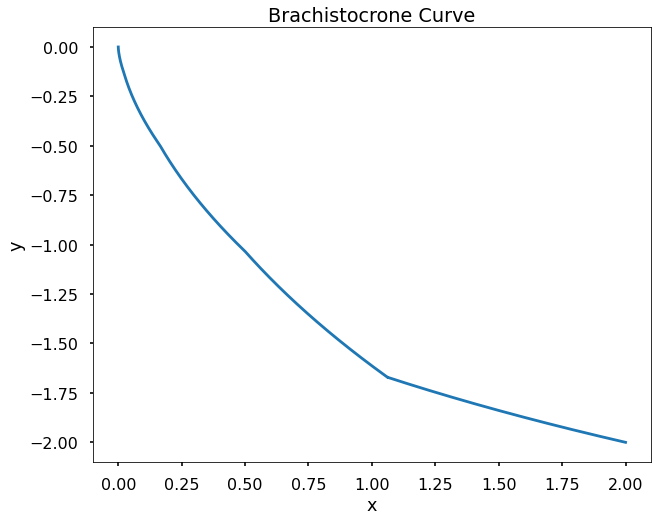

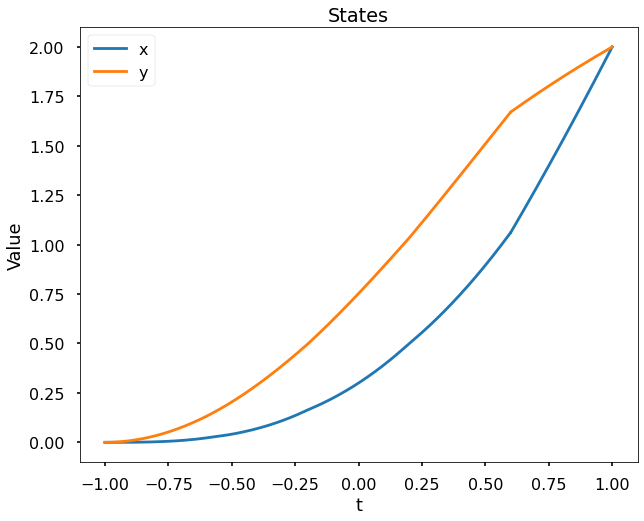

In [6]:
multiple_shooting(initial_states, final_states, guesses, K, is_print=True)